# Modelling test - Monsoon Credittech

#### Problem statement and given data

1. Dataset provided by a lending company. 
2. Contains application details of all previous loans they have disbursed. 
3. The data has information collected at the time of application and a marker to identify a loan as a default case or a loan that was paid on time. 
4. Both training data and testing data consist of a __flag file__, __accounts data__ and __enquiry data__. 
5. Accounts data consists of details of loans taken by the borrower before they applied for a loan (loan histories of clients essentially). These details were collected when the borrower applied for a loan from the client. 
6. Enquiry data contains details of previous loan applications made by the applicant (loan application histories of clients essentially). 
7. Training flag data consists of records of applicant ids of borrowers and if they repaid their loans. 0 = good loan and 1 = bad loan. 
8. Accounts data, enquiry data and flag data need to be merged and then feature selection needs to be performed. 


## 1. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
### 1.1 [Imports](#All-imports)
### 1.2 [Data](#Data)
### 1.3 [Train accounts data](#Train-accounts-data)
#### 1.3.1 [Countplot of credit types](#Countplot-of-credit-types)
#### 1.3.2 [Analysis of loan amounts](#Analysis-of-loan-amounts)
#### 1.3.3 [Analysis of payment history](#Conversion-of-payment-history-string)
#### 1.3.4 [Temporal analysis of loans](#Temporal-analysis-of-loans)
#### 1.3.5 [Correlation matrix](#Correlation-matrix-between-features)
### 1.4 [Train enquiry data](#Train-enquiry-data)
#### 1.4.1 [Countplot of enquiry types](#Countplot-of-enquiry-types)
#### 1.4.2 [Exploring enquiry amounts](#Exploring-enquiry-amounts)
#### 1.4.3 [Temporal analysis of enquiries](#Temporal-analysis-of-enquiries)
### 1.5 [Train flag](#Train-flag)
#### 1.5.1 [Countplot of contract types](#Countplot-of-contract-types)
#### 1.5.2 [Countplot of good and bad loans](#Countplot-of-good-and-bad-loans)
## 2. [Feature Selection](#Feature-selection)
### 2.1 [Merging dataframes](#Merging-dataframes)
### 2.2 [Choosing important features](#Choosing-important-features)
### 2.3 [Scaling](#Scaling)
## 3. [Training and predicting](#Training-and-predicting)
### 3.1 [Training a classifier](#Training-a-classifier)
### 3.2 [Making predictions](#Making-predictions)











## Exploratory Data Analysis

### All imports

In [1]:
#!pip install requirments.txt

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings('ignore')

### Data


In [51]:
def read_json(path):
    with open(path, 'r') as f:
        data = json.load(f)
    flattened_data = [item for sublist in data for item in sublist]
    df = pd.DataFrame(flattened_data)
    return df

train_flag = pd.read_csv(r"..\data\train\train_flag.csv")
train_accounts_data = read_json(r"..\data\train\accounts_data_train.json")
train_enquiry_data = read_json(r"..\data\train\enquiry_data_train.json")

test_flag = pd.read_csv(r"..\data\test\test_flag.csv")
test_accounts_data = read_json(r"..\data\test\accounts_data_test.json")
test_enquiry_data = read_json(r"..\data\test\enquiry_data_test.json")

We can see that all 3 dataframes in the training data are linked by the uid, which uniquely identifies each loan applicant.The 'TARGET' column (originally from the train_flag) will be the label with 0 being a good loan and 1 being a bad loan (presumably a case of defaulting). For a given uid, train_accounts_data contains the history of loans taken by that applicant, train_enquiry_data contains the history of loan applications made by the applicant, train_flag contains a history of loans given out by the client to a particular borrower, with an indication of whether or not they were successful. 

### Train accounts data

In [100]:
train_accounts_data.shape

(1245310, 7)

In [101]:
train_accounts_data.describe()

,loan_amount,amount_overdue
count,1.245307e+06,1.245310e+06
mean,3.523541e+05,4.202288e+01
std,1.109812e+06,6.668687e+03
min,0.000000e+00,0.000000e+00
25%,5.114700e+04,0.000000e+00
50%,1.246590e+05,0.000000e+00
75%,3.087000e+05,0.000000e+00
max,3.960000e+08,3.756681e+06


In [65]:
train_accounts_data.head(5)

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
0,Consumer credit,272745.000,0.0,2018-09-22,2020-02-22,0000000000000000000000100000000000000000000000...,AAA09044550
1,Consumer credit,4500.000,0.0,2018-03-08,2019-07-25,000000000000000014044000000000000000000000000000,AAA09044550
2,Credit card,80996.445,0.0,2020-06-29,NaN,000000000000000000,AAA10545297
3,Consumer credit,43771.500,0.0,2020-06-09,2020-09-09,000000000,AAA14112888
4,Credit card,10480.500,0.0,2014-09-10,NaN,0000000000000000000000000000000000000000000000...,AAA20326915


In [150]:
# Check for missing values
missing_values = train_accounts_data.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 credit_type                 0
loan_amount                 3
amount_overdue              0
open_date                   0
closed_date            463035
payment_hist_string         0
uid                         0
overdue_category            0
payment_hist_int            0
number_of_months            0
dtype: int64


In [3]:
#Dropping rows where loan amount is null, since they won't contribute. 

train_accounts_data.dropna(subset = ['loan_amount'], inplace = True)

In [57]:
train_accounts_data['uid'].nunique()

223918

The client has loan histories of 223918 applicants. 

In [64]:
train_accounts_data['credit_type'].unique()

array(['Consumer credit', 'Credit card', 'Mortgage', 'Car loan',
       'Loan for business development', 'Microloan',
       'Another type of loan', 'Loan for working capital replenishment',
       'Unknown type of loan', 'Loan for the purchase of equipment',
       'Real estate loan', 'Cash loan (non-earmarked)',
       'Loan for purchase of shares (margin lending)', 'Interbank credit',
       'Mobile operator loan'], dtype=object)

#### Countplot of credit types

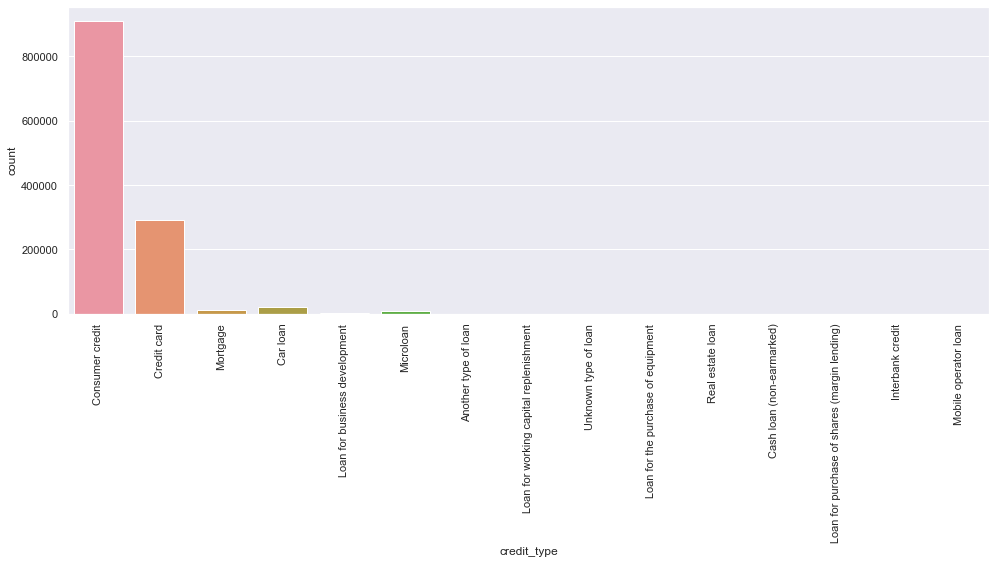

In [140]:
#Plotting all credit_types

plt.figure(figsize=(14, 8))
sns.set(rc={'figure.autolayout': True})
sns.countplot(data=train_accounts_data, x='credit_type')
plt.xticks(rotation=90)
plt.show()

As we can see, in the history of loans available an overwhelming majority are Consumer credit. 

#### Analysis of loan amounts

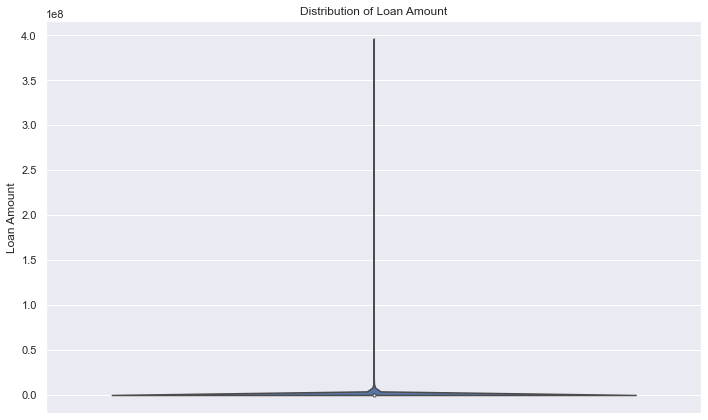

In [82]:
#Violin plot of loan amounts
plt.figure(figsize=(10, 6))

# Ensure no overlapping of text
sns.set(rc={'figure.autolayout': True})

# Plot box plot of loan_amount
sns.violinplot(data=train_accounts_data, y='loan_amount')
plt.ylabel('Loan Amount')
plt.title('Distribution of Loan Amount')
plt.show()

As we see the plot is very skewed, due to some very high loan amount values which are possibly outliers. Perhaps, making a violin plot of only values below a threshold may make the plot clearer. However, the high values shouldn't be excluded from the original dataframe because they may contain valuable insight. Loan amounts can also be categorised based on whether or not people had overdues while repaying the loans. 

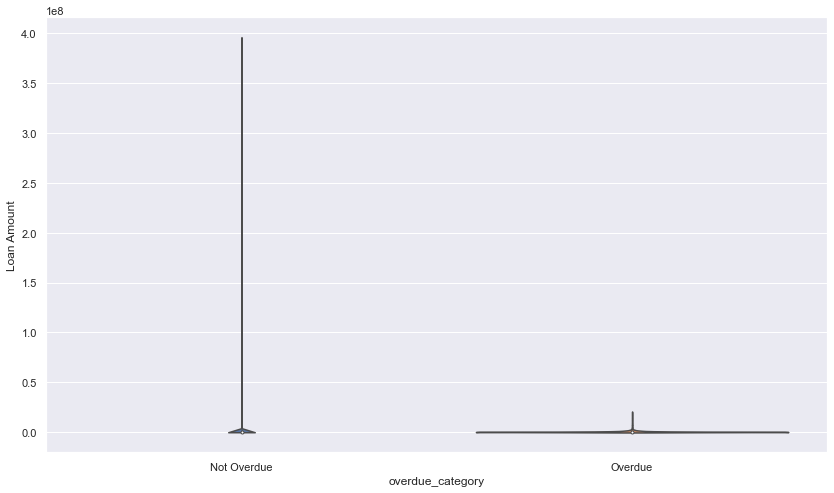

In [4]:
train_accounts_data['overdue_category'] = train_accounts_data['amount_overdue'].apply(lambda x: 'Overdue' if x > 0 else 'Not Overdue')


plt.figure(figsize=(14, 8))

sns.set(rc={'figure.autolayout': True})
sns.violinplot(data=train_accounts_data, y='loan_amount', x='overdue_category')
plt.ylabel('Loan Amount')
plt.show()

In [111]:
print(f"The minimum loan amount is {train_accounts_data['loan_amount'].min()}.")
print(f"The maximum loan amount is {train_accounts_data['loan_amount'].max()}.")
print(f"The average loan amount is {train_accounts_data['loan_amount'].mean()}.")
print(f"The standard deviation in loan amounts is {train_accounts_data['loan_amount'].std()}.")
print(f"The standard devaition in overdue amounts is {train_accounts_data['amount_overdue'].std()}.")

The minimum loan amount is 0.0.
The maximum loan amount is 396000000.0.
The average loan amount is 352354.1154550864.
The standard deviation in loan amounts is 1109811.561194547.
The standard devaition in overdue amounts is 6668.687320491774.


We can further explore the data where people had dues in repaying loans. The number of such cases is 3091. So, the large majority of data includes information about borrowers who had no overdues. 

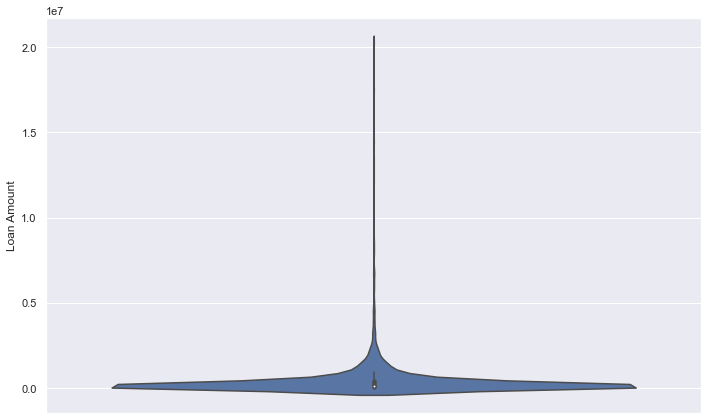

In [98]:
overdue_accounts = train_accounts_data[train_accounts_data_copy['overdue_category'] == 'Overdue']

plt.figure(figsize=(10, 6))

sns.set(rc={'figure.autolayout': True})
sns.violinplot(data=overdue_accounts, y='loan_amount')
plt.ylabel('Loan Amount')
plt.show()

In [196]:
print(f"The number of loans with positive overdue are {overdue_accounts['loan_amount'].count()}")
print(f"The minimum loan amount is {overdue_accounts['loan_amount'].min()} for overdue accounts.")
print(f"The maximum loan amount is {overdue_accounts['loan_amount'].max()} for overdue accounts.")
print(f"The average loan amount is {overdue_accounts['loan_amount'].mean()} for overdue accounts.")
print(f"The standard deviation in loan amounts is {overdue_accounts['loan_amount'].std()} for overdue accounts")
print(f"The standard devaition in overdue amounts is {overdue_accounts['amount_overdue'].std()} for overdue accounts. ")

The number of loans with positive overdue are 3091
The minimum loan amount is 0.0 for overdue accounts.
The maximum loan amount is 20280150.0 for overdue accounts.
The average loan amount is 419025.8918084762 for overdue accounts.
The standard deviation in loan amounts is 968805.6782709671 for overdue accounts
The standard devaition in overdue amounts is 132802.54528106333 for overdue accounts. 


Given the massive amount of standard deviation in loan amounts and overdue amounts, it would make sense to scale the features chosen for training. Else loan_amount and overdue_amount would dominate over the other features. 

The payment history of a borrower is a crucial feature in determining whether he/she will default on a loan. This string needs to be converted into values which can be used for prediction. Since three digits represent number of days by which a payment was overdue, we can take three digits at a time, convert them to an integer and then keep adding them. This gives us the total number of overdue days, which can serve as an important feature. 

#### Conversion of payment history string

In [5]:
def compute_overdue_days(payment_hist):
    nums = [int(payment_hist[i:i+3]) for i in range(0, len(payment_hist), 3)]
    return sum(nums)

train_accounts_data['payment_hist_int'] = train_accounts_data['payment_hist_string'].apply(compute_overdue_days)

In [119]:
print(f"The minimum number of total overdue days is {train_accounts_data['payment_hist_int'].min()}.")
print(f"The maximum number of total overdue days is {train_accounts_data['payment_hist_int'].max()}.")
print(f"The average total overdue days is {train_accounts_data['payment_hist_int'].mean()}.")
print(f"The standard deviation in total overdue days is {train_accounts_data['payment_hist_int'].std()}.")

The minimum number of total overdue days is 0.
The maximum number of total overdue days is 42242.
The average total overdue days is 37.82045514771422.
The standard deviation in total overdue days is 524.0890038715881.


Using the payment_hist_string column, it is also possible to compute how long each loan has been open. Since 3 digits in payment_hist_string column represent 1 month, we divide the length of payment_hist_column by 3. 

In [6]:
train_accounts_data['number_of_months'] = train_accounts_data['payment_hist_string'].apply(lambda x:len(x)//3)

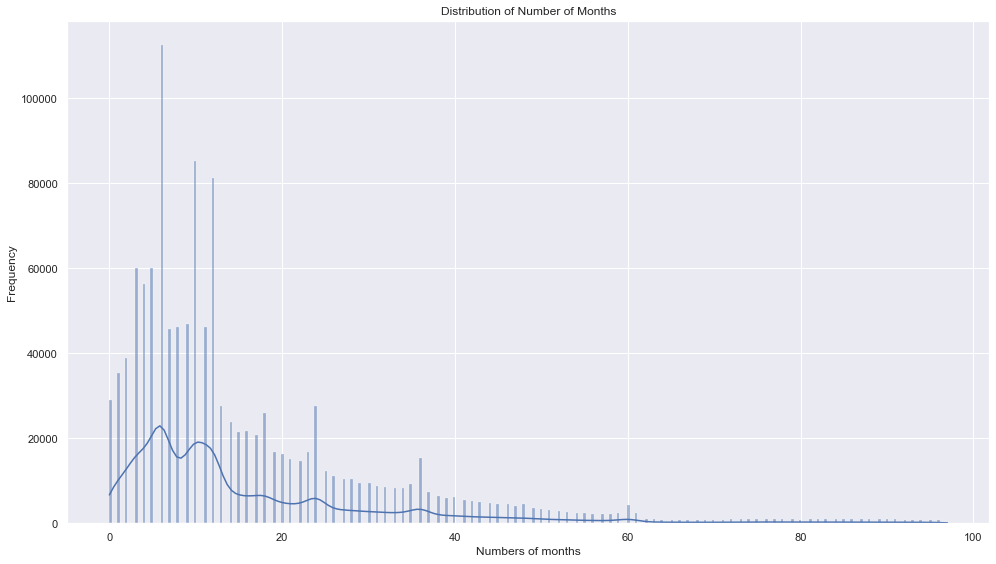

In [154]:
plt.figure(figsize=(14, 8))

sns.set(rc={'figure.autolayout': True})

sns.histplot(data=train_accounts_data, x='number_of_months', kde=True)
plt.xlabel('Number of months')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Months')
plt.show()

We see that the maximum amount of time most loans have been open is around 25 months. 

#### Temporal analysis of loans

It is also possible to segregate loans based on the months when they were opened. 

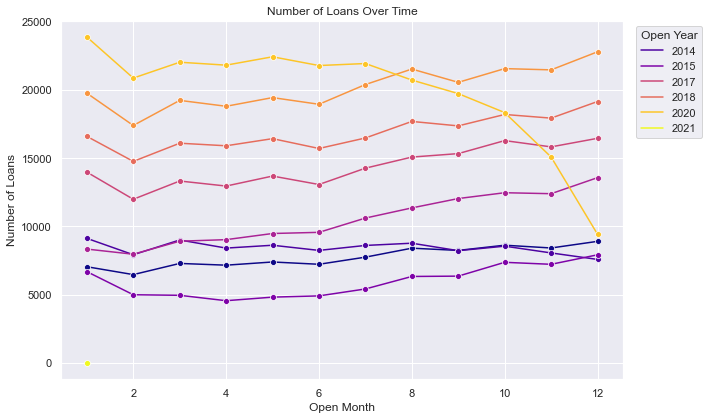

In [162]:
train_accounts_data_copy = train_accounts_data.copy(deep = True)

train_accounts_data_copy['open_date'] = pd.to_datetime(train_accounts_data_copy['open_date'])

# Extract year and month from 'open_date'
train_accounts_data_copy['open_year'] = train_accounts_data_copy['open_date'].dt.year
train_accounts_data_copy['open_month'] = train_accounts_data_copy['open_date'].dt.month

# Count number of loans by year and month
loan_count_by_month = train_accounts_data_copy.groupby(['open_year', 'open_month']).size().reset_index(name='loan_count')

# Set figure size
plt.figure(figsize=(10, 6))

# Ensure no overlapping of text
sns.set(rc={'figure.autolayout': True})

# Plot line plot for number of loans over time
sns.lineplot(data=loan_count_by_month, x='open_month', y='loan_count', hue='open_year', palette = 'plasma', marker='o')
plt.xlabel('Open Month')
plt.ylabel('Number of Loans')
plt.title('Number of Loans Over Time')
plt.legend(title='Open Year', loc='upper right', bbox_to_anchor=(1.15, 1.0))
plt.show()

The above plot demonstrates that most loans were opened in January or December. This is just an interesting seasonal trend for observation, but has no direct correlation with defaulting on a loan. 

With the extra features, here is what the dataframe now looks like:

In [163]:
train_accounts_data.head(5)

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid,overdue_category,payment_hist_int,number_of_months
0,Consumer credit,272745.000,0.0,2018-09-22,2020-02-22,0000000000000000000000100000000000000000000000...,AAA09044550,Not Overdue,10,17
1,Consumer credit,4500.000,0.0,2018-03-08,2019-07-25,000000000000000014044000000000000000000000000000,AAA09044550,Not Overdue,58,16
2,Credit card,80996.445,0.0,2020-06-29,NaN,000000000000000000,AAA10545297,Not Overdue,0,6
3,Consumer credit,43771.500,0.0,2020-06-09,2020-09-09,000000000,AAA14112888,Not Overdue,0,3
4,Credit card,10480.500,0.0,2014-09-10,NaN,0000000000000000000000000000000000000000000000...,AAA20326915,Not Overdue,14477,76


#### Correlation matrix between features

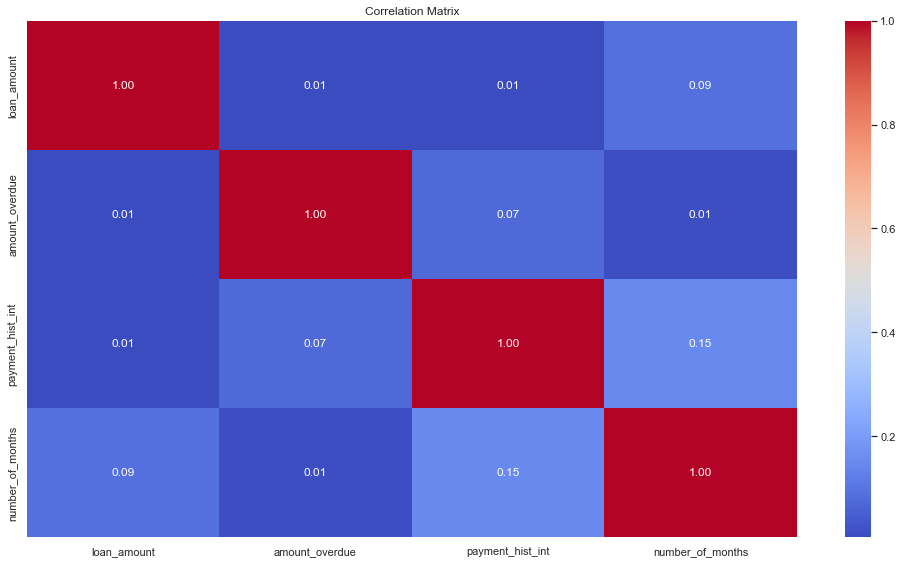

In [156]:
correlation_matrix = train_accounts_data[['loan_amount', 'amount_overdue', 'payment_hist_int', 'number_of_months']].corr()

plt.figure(figsize=(14, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 12})
plt.title('Correlation Matrix')
plt.show()

The correlation matrix shows that no two numerical features are highly correlated, so we keep all of them. Feature selection is not done yet, we do it after merging the dataframes.

### Train enquiry data

In [127]:
train_enquiry_data.shape

(1909926, 4)

In [128]:
train_enquiry_data.describe()

,enquiry_amt
count,1.909926e+06
mean,1.160423e+05
std,8.207031e+04
min,1.007000e+03
25%,5.600000e+04
50%,1.080000e+05
75%,1.590000e+05
max,4.999950e+05


In [165]:
missing_values = train_enquiry_data.isnull().sum()
print("Missing Values:\n", missing_values)

#No values are missing. 

Missing Values:
 enquiry_type    0
enquiry_amt     0
enquiry_date    0
uid             0
dtype: int64


In [130]:
train_enquiry_data['enquiry_type'].nunique()

17

In [126]:
train_enquiry_data.head(5)

,enquiry_type,enquiry_amt,enquiry_date,uid
0,Interbank credit,168839,2020-11-08,AAA08065248
1,Mobile operator loan,268392,2020-09-20,AAA08065248
2,Mobile operator loan,36082,2020-06-19,AAA08065248
3,Interbank credit,180467,2019-10-22,AAA08065248
4,Cash loan (non-earmarked),227459,2020-05-24,AAA08065248


#### Countplot of enquiry types

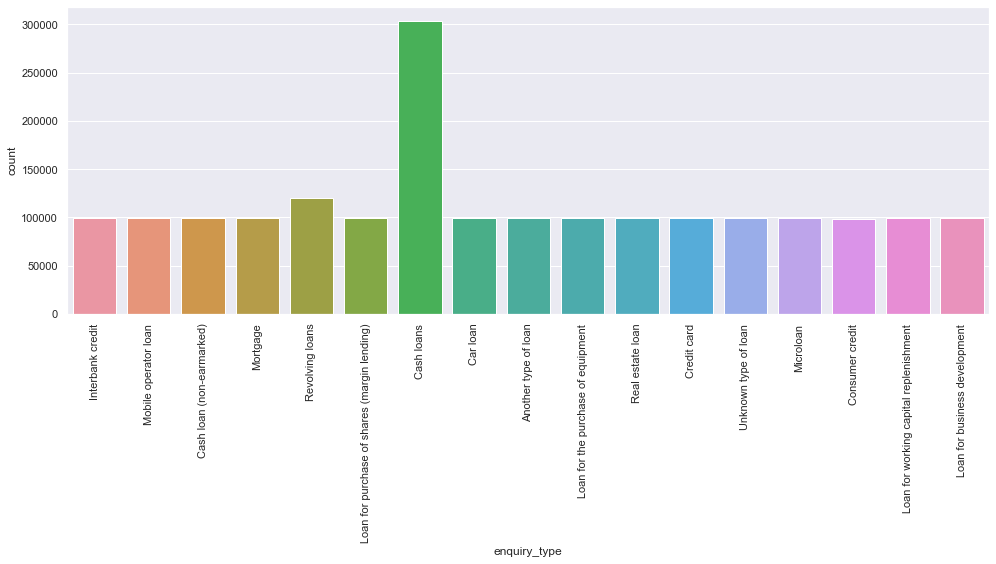

In [138]:
#Plotting all credit_types

plt.figure(figsize=(14, 8))
sns.set(rc={'figure.autolayout': True})
sns.countplot(data=train_enquiry_data, x='enquiry_type')
plt.xticks(rotation=90)
plt.show()

We see that most of the enquiries are cash loans, with the remaining loans being equally divided. 

In [132]:
train_enquiry_data['uid'].nunique()

261383

Our client has enquiry data of 261383 borrowers. 

#### Exploring enquiry amounts

In [197]:
print(f"The minimum loan enquiry amount is {train_enquiry_data['enquiry_amt'].min()}.")
print(f"The maximum loan enquiry amount is {train_enquiry_data['enquiry_amt'].max()}.")
print(f"The average loan enquiry amount is {train_enquiry_data['enquiry_amt'].mean()}.")
print(f"The standard deviation in loan enquiry amount is {train_enquiry_data['enquiry_amt'].std()}.")

The minimum loan enquiry amount is 1007.
The maximum loan enquiry amount is 499995.
The average loan enquiry amount is 116042.27008585673.
The standard deviation in loan enquiry amount is 82070.30940594495.


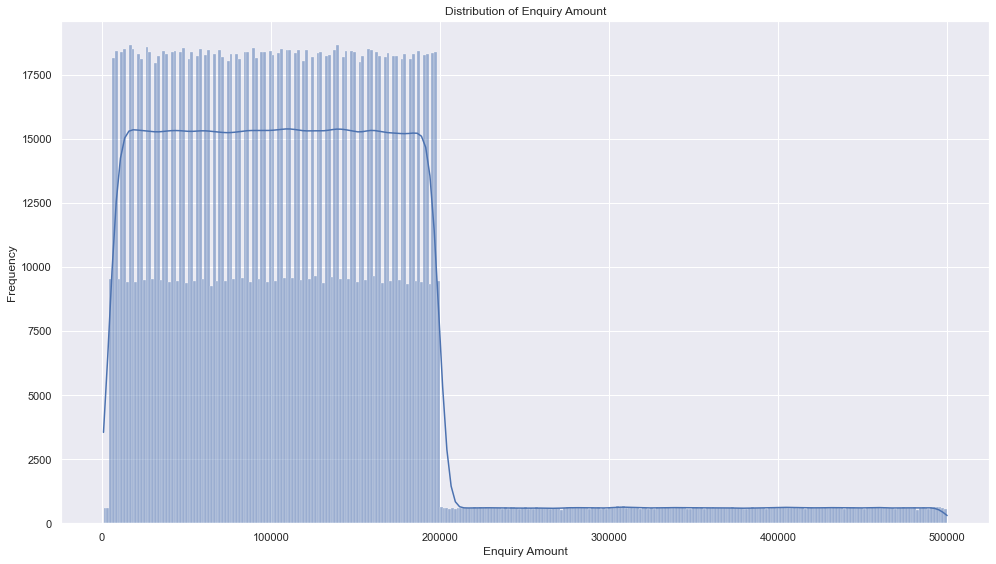

In [142]:
#Plotting a kde of enquiry amounts

plt.figure(figsize=(14, 8))

# Ensure no overlapping of text
sns.set(rc={'figure.autolayout': True})

# Plot histogram and KDE plot for 'enquiry_amt'
sns.histplot(data=train_enquiry_data, x='enquiry_amt', kde=True)
plt.xlabel('Enquiry Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Enquiry Amount')
plt.show()

We see that most enquiries range upto 200000. 

#### Temporal analysis of enquiries

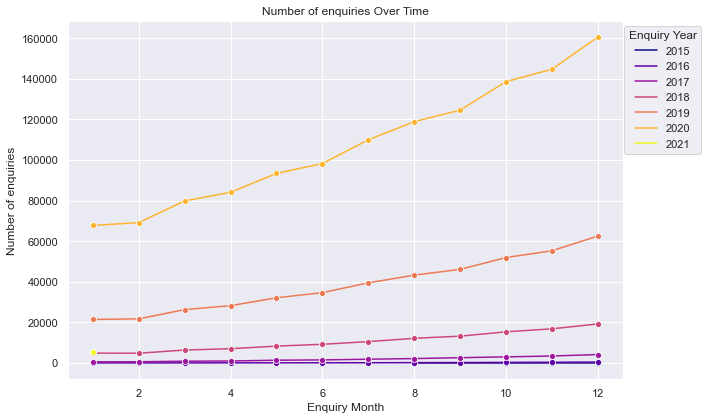

In [183]:
train_enquiry_data_copy = train_enquiry_data.copy(deep = True)

train_enquiry_data_copy['enquiry_date'] = pd.to_datetime(train_enquiry_data_copy['enquiry_date'])

# Extract year and month from 'enquiry_date'
train_enquiry_data_copy['enquiry_year'] = train_enquiry_data_copy['enquiry_date'].dt.year
train_enquiry_data_copy['enquiry_month'] = train_enquiry_data_copy['enquiry_date'].dt.month

# Count number of enquiries by year and month
enquiry_count_by_month = train_enquiry_data_copy.groupby(['enquiry_year', 'enquiry_month']).size().reset_index(name='enquiry_count')


plt.figure(figsize=(10, 6))

# Ensure no overlapping of text
sns.set(rc={'figure.autolayout': True})

# Plot line plot for number of enquiries over time
sns.lineplot(data=enquiry_count_by_month, x='enquiry_month', y='enquiry_count', hue='enquiry_year', palette = 'plasma', marker='o')
plt.xlabel('Enquiry Month')
plt.ylabel('Number of enquiries')
plt.title('Number of enquiries Over Time')
plt.legend(title='Enquiry Year', loc='upper right', bbox_to_anchor=(1.15, 1.0))
plt.show()

For most years, the enquiries increase towards the end of the year. 

### Train flag

In [167]:
missing_values = train_flag.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 uid                   0
NAME_CONTRACT_TYPE    0
TARGET                0
dtype: int64


In [198]:
train_flag.head(5)

,uid,NAME_CONTRACT_TYPE,TARGET
0,XDA69787158,Cash loans,0
1,BSE47789733,Cash loans,0
2,NTJ92213825,Cash loans,0
3,TCQ47571695,Cash loans,0
4,WJZ68772744,Cash loans,0


The number of unique ids in train_flag is same as the number of unique ids in train_enquiry_data. 

#### Countplot of contract types

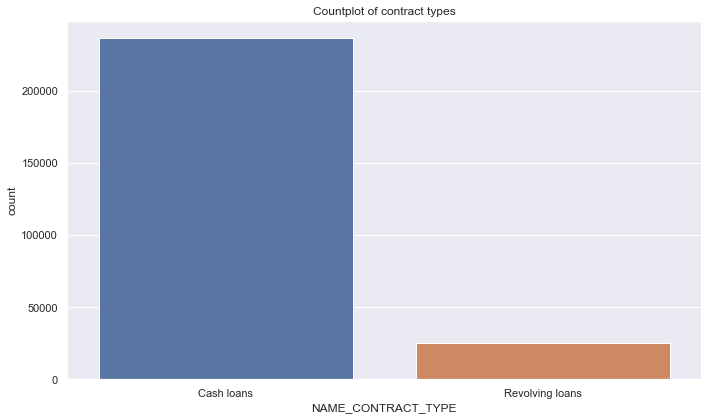

In [189]:
plt.figure(figsize=(10, 6))
sns.set(rc={'figure.autolayout': True})
sns.countplot(data=train_flag, x='NAME_CONTRACT_TYPE')
plt.title('Countplot of contract types')
plt.show()

In [178]:
n_cash_loans = train_flag[train_flag['NAME_CONTRACT_TYPE']=='Cash loans']['NAME_CONTRACT_TYPE'].count()
n_revolving_loans = train_flag[train_flag['NAME_CONTRACT_TYPE']=='Revolving loans']['NAME_CONTRACT_TYPE'].count()

print(f"The number of cash loans are {n_cash_loans}.")
print(f"The number of revolving loans are {n_revolving_loans}.")

The number of cash loans are 236524.
The number of revolving loans are 24859.


There are only 2 types of loans in the disbursement history of the client. 

#### Countplot of good and bad loans

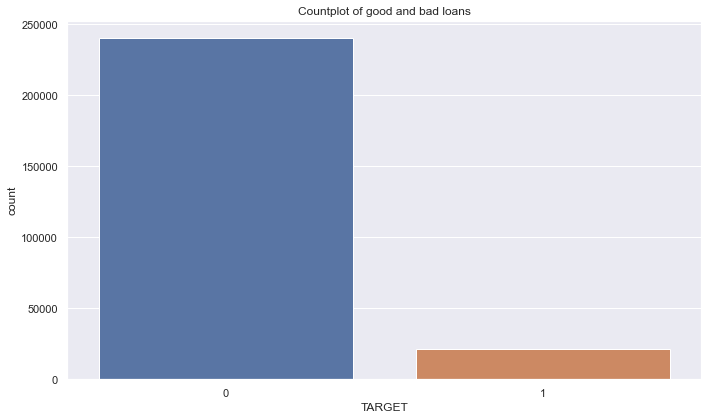

In [190]:
plt.figure(figsize=(10, 6))
sns.set(rc={'figure.autolayout': True})
sns.countplot(data=train_flag, x='TARGET')
plt.title('Countplot of good and bad loans')
plt.show()

Dividing good and bad loans into cash loans and revolving loans is a good way of understanding if a particular kind of loan is more likely to be bad. 

In [180]:
n_good_loans = train_flag[train_flag['TARGET']==0]['TARGET'].count()
n_bad_loans = train_flag[train_flag['TARGET']==1]['TARGET'].count()

print(f"The number of good loans are {n_good_loans}.")
print(f"The number of bad loans are {n_bad_loans}.")

The number of good loans are 240326.
The number of bad loans are 21057.


In [185]:
n_good_cash_loans = train_flag[(train_flag['TARGET']==0) & (train_flag['NAME_CONTRACT_TYPE'] == 'Cash loans')]['TARGET'].count()
n_good_revolving_loans = train_flag[(train_flag['TARGET']==0) & (train_flag['NAME_CONTRACT_TYPE'] == 'Revolving loans')]['TARGET'].count()

n_bad_cash_loans = n_cash_loans - n_good_cash_loans
n_bad_revolving_loans = n_revolving_loans - n_good_revolving_loans

print(f"The number of good cash loans and bad cash loans are {n_good_cash_loans} and {n_bad_cash_loans}.")
print(f"The number of good revolving loans and bad revolving loans are {n_good_revolving_loans} and {n_bad_revolving_loans}.")


The number of good cash loans and bad cash loans are 216823 and 19701.
The number of good revolving loans and bad revolving loans are 23503 and 1356.


In [186]:
df_good_loans = train_flag[train_flag['TARGET']==0]
df_bad_loans = train_flag[train_flag['TARGET']==1]

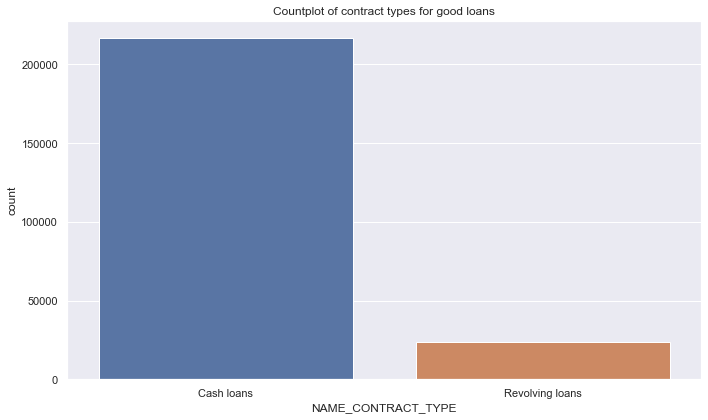

In [191]:
#Countplot of contract types for good loans

plt.figure(figsize=(10, 6))
sns.set(rc={'figure.autolayout': True})
sns.countplot(data=df_good_loans, x='NAME_CONTRACT_TYPE')
plt.title('Countplot of contract types for good loans')
plt.show()

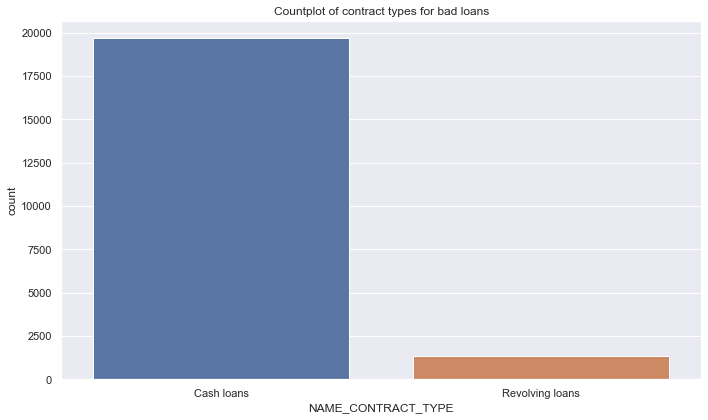

In [192]:
#Countplot of contract types for bad loans

plt.figure(figsize=(10, 6))
sns.set(rc={'figure.autolayout': True})
sns.countplot(data=df_bad_loans, x='NAME_CONTRACT_TYPE')
plt.title('Countplot of contract types for bad loans')
plt.show()

We see that in all cases, the number of cash loans is far more than revolving loans and contribute more to the study. We also notice there is no obvious correlation between the types of loans and whether they end up being good or bad. Hence, we preserve both cash loans and revolving loans. 

In [195]:
print(f"The percentage of cash loans is {round((n_cash_loans/train_flag['TARGET'].count())*100, 2)}")

The percentage of cash loans is 90.49


## Feature selection

### Merging dataframes

The dataframes train_accounts_data, train_enquiry_data and train_flag need to be merged and then important features from the combined dataframe need to be chosen.

The predictions need to be done based on a combination of test_accounts_data, test_enquiry_data and test_flag dataframe. The train_flag dataframe has a __TARGET__ column, which the test_flag dataframe does not have. We are supposed to predict a similar __TARGET__ column for the test dataframes. 

In [235]:
test_flag['NAME_CONTRACT_TYPE'].unique()

array(['Cash loans', 'Revolving loans'], dtype=object)

The test_flag dataframe only has 2 types of loans - cash loans and revolving loans, similar to the train_flag dataframe. This indicates that either out client only gives out cash loans and revolving loans or are interested in making predictions for these 2 types of loans. The train_enquiry dataset can be filtered out for these 2 kinds of loans. The same filtereing is later done for the test_enquiry dataset. 


In [7]:
train_enquiry_filtered = train_enquiry_data[(train_enquiry_data['enquiry_type'] == 'Cash loans') | (train_enquiry_data['enquiry_type'] == 'Revolving loans')]

Now comes the part where we merge the 3 dataframes. A quick brief recap of what each dataframe contains - __train_enquiry_data__ is the history of loan applications of borrowers, __train_flag__ is the history of loans disbursed by the client and __train_accounts_data__ is the loan history of borrowers before they applied for a loan with our client. For a particular uid, __train_flag__ cannot have an entry without a corresponding entry in __train_enquiry_data__, because it is not possible for a borrower to get a loan without an enquiry in the first place. In addition, it is possible for a borrower to have no history of loans before availing a loan from our client. Hence, __train_accounts_data__ should be merged at the end. 

For every uid in the __train_flag__ dataframe, there may be multiple rows in the __train_enquiry_data__. Since, it does not make sense to cross join every row from one dataframe with every row from the other dataframe, we sort the values based on certain columns and keep only the first occurence based on the uid column. Here are all steps with logic used for joining the dataframes -

1. Left join __train_enquiry_filtered__ with __train_flag__ on the uid column.  
2. Merge this dataframe with train_accounts_data. 
3. Groupby this dataframe based on uid and then sum up the remaining columns, which accumulates the 'credit score' of sorts, for each unique uid. 
4. We then focus on which features to preserve and feed to a classifier. 

In [30]:
X_train = pd.merge(train_flag, train_enquiry_filtered, on = 'uid', how = 'left')
X_train = pd.merge(X_train, train_accounts_data, how = 'left')
X_train = X_train[['uid', 'enquiry_amt', 'loan_amount', 'amount_overdue', 'payment_hist_int', 'number_of_months', 'TARGET']]
X_train = X_train.groupby('uid').sum()
X_train['TARGET'] = X_train['TARGET'].apply(lambda x:1 if x>1 else x)
X_train.fillna(0, inplace = True)

### Choosing important features

Features to remove - 
1. UID - the id of a person will not logically help a model to make prediction. This column served its purpose which was to merge the dataframes. 
2. enquiry_date 
3. NAME_CONTRACT_TYPE - since there was no correlation between NAME_CONTRACT_TYPE and TARGET. 
4. enquiry_type - Since we filtered rows with enquiry_type == NAME_CONTRACT_TYPE. 
5. payment_hist_string - the string by itself cannot be used for any computation, but the columns 'payment_hist_int' and 'number_of_months' have been derived from it, which are useful. 
6. credit_type - the type of loan taken in the past does not affect predictions as much as the amount taken does. 
7. open_date and closed_date - we get the necessary information from number_of_months. 
8. overdue_category - this is not needed as the amount_overdue category serves the purpose. 

In [32]:
X_train_final = X_train[['enquiry_amt', 'loan_amount', 'amount_overdue', 'payment_hist_int', 'number_of_months']]
y_train_final = X_train['TARGET']

### Scaling 

Given the disparity in the scales of chosen features, it is a good idea to scale them. I use the standard scaler because it is not sensitive to outliers. 

In [33]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)

## Training and predicting

### Training a classifier

The predictions are done using a support vector machine, while accounting for class weights. Support vector machine is generally robust and can handle not linear data, even in higher dimensions. 

In [286]:
print(f"The ratio of good loans to bad loans in train_flag is {train_flag[train_flag['TARGET'] == 0]['TARGET'].count()/train_flag[train_flag['TARGET'] == 1]['TARGET'].count()}")

The ratio of good loans to bad loans in train_flag is 11.41311677826851


Since good loans are far more prevelant than bad loans, we account for class weights using class_weight. 

In [34]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_final), y=y_train_final)

In [36]:
svm_classifier = SVC(kernel='poly', class_weight=dict(enumerate(class_weights)))
svm_classifier.fit(X_train_scaled, y_train_final)

SVC(class_weight={0: 0.543809242445678, 1: 6.206558389134255}, kernel='poly')

### Making predictions

A similar process is followed to create an X_test dataset, which is also scaled using the standard scaler. 

In [59]:
test_accounts_data['payment_hist_int'] = test_accounts_data['payment_hist_string'].apply(compute_overdue_days)
test_accounts_data['number_of_months'] = test_accounts_data['payment_hist_string'].apply(lambda x:len(x)//3)

test_enquiry_filtered = test_enquiry_data[(test_enquiry_data['enquiry_type'] == 'Cash loans') | (test_enquiry_data['enquiry_type'] == 'Revolving loans')]

X_test = pd.merge(test_flag, test_enquiry_filtered, on = 'uid', how = 'left')
X_test = pd.merge(X_test, test_accounts_data, how = 'left')
X_test = X_test[['uid', 'enquiry_amt', 'loan_amount', 'amount_overdue', 'payment_hist_int', 'number_of_months']]
X_test = X_test.groupby('uid').sum()
X_test.fillna(0, inplace = True)
X_test_final = X_test[['enquiry_amt', 'loan_amount', 'amount_overdue', 'payment_hist_int', 'number_of_months']]
X_test_scaled = scaler.transform(X_test_final)

In [60]:
#Making predictions on the scaled test dataset

predictions = svm_classifier.predict(X_test_scaled)

In [61]:
test_flag_copy = test_flag.copy(deep = True)
test_flag_copy['pred'] = predictions
test_flag_copy = test_flag_copy[['uid', 'pred']]

In [54]:
#Saving results

test_flag_copy.to_csv('../data/final_submission/final_submissions.csv', index = False)